In [1]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix

In [2]:
train_data_dir = os.path.join('train')
valid_data_dir = os.path.join('val')
test_data_dir = os.path.join('test')

batchSize = 32
size = 256
img_size = (size, size)

train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    label_mode = "categorical",
    batch_size=batchSize,
    image_size = img_size
)

number_of_classes = len(train_data.class_names)
class_names= train_data.class_names


valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_data_dir,
    label_mode = "categorical",
    batch_size=batchSize,
    image_size = img_size
)


test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = "categorical",
    batch_size=batchSize,
    image_size = img_size
)

Found 4200 files belonging to 6 classes.
Found 600 files belonging to 6 classes.
Found 1199 files belonging to 6 classes.


In [3]:
print(number_of_classes)
print(class_names)

6
['Asian-Green-Bee-Eater', 'Coppersmith-Barbet', 'Jungle-Babbler', 'No Bird Detected', 'Rose Ringed Parakeet', 'White-Breasted-Kingfisher']


In [4]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast, RandomTranslation

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomFlip("vertical"),
  RandomRotation(0.7),
  RandomZoom(0.25),  
  RandomBrightness(0.1),
  RandomContrast(0.1)
])

train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

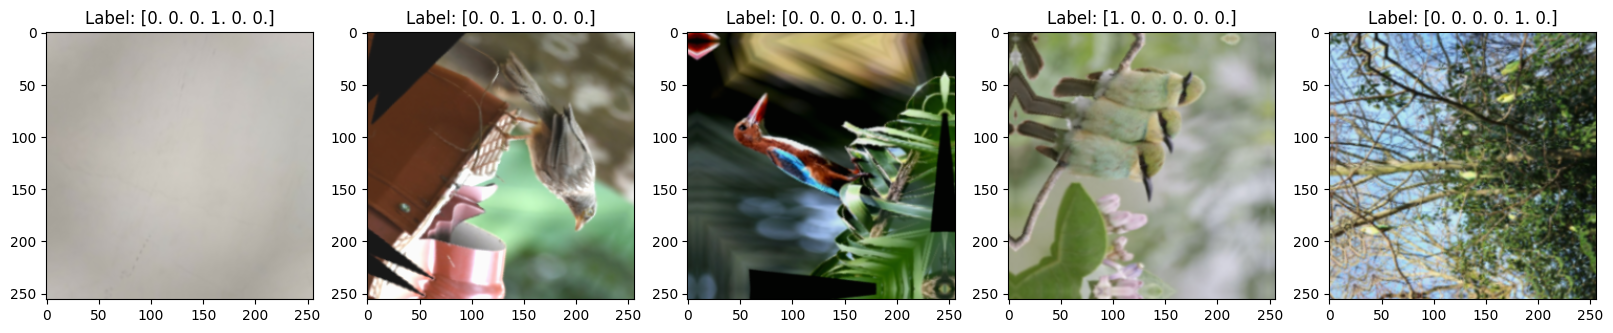

In [5]:
# Visualize augmented images
batch = next(train_data.as_numpy_iterator())  # Get a batch
images, labels = batch
augmented_images = data_augmentation(images)
augmented_images = augmented_images.numpy() / 255.0 # Normalize for visualization

fig, axs = plt.subplots(ncols=5, figsize=(20, 20))
for index, image in enumerate(augmented_images[0:5]):
  axs[index].imshow(image)
  axs[index].title.set_text(f"Label: {labels[index]}")
plt.show()

In [6]:
train_data.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))

In [7]:
lambd = 0.0005 
convDropout = 0.3
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3), kernel_regularizer=regularizers.l2(lambd)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))  
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2)))

# Second convolutional block
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(MaxPooling2D((2, 2)))

# Third convolutional block
model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(MaxPooling2D((2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(Dense(256, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))

model.summary()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,833,606 (10.81 MB)

 Trainable params: 2,833,478 (10.81 MB)

 Non-trainable params: 128 (512.00 B)

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=7)  
tensorboard_callback = TensorBoard(log_dir='logs')

checkpoint = "checkpoint_model.keras"
model_checkpoint = ModelCheckpoint(filepath=checkpoint, monitor='val_categorical_accuracy', save_best_only=True)

def scheduler(epoch, lr):
    if epoch < 14:
        return lr
    elif epoch > 12 and epoch <= 18:
        return 0.0005
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(scheduler)

hist = model.fit(
    train_data,
    epochs=50,
    validation_data=valid_data,
    callbacks=[early_stopping, tensorboard_callback, model_checkpoint, lr_scheduler]
)
# lambda = 0.0001
# learning rate = 0.0001
# convDropout = 0.3

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - categorical_accuracy: 0.3306 - loss: 2.8146 - val_categorical_accuracy: 0.5467 - val_loss: 2.0001 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - categorical_accuracy: 0.5699 - loss: 1.8122 - val_categorical_accuracy: 0.6867 - val_loss: 1.5084 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - categorical_accuracy: 0.6584 - loss: 1.4732 - val_categorical_accuracy: 0.5367 - val_loss: 1.8201 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - categorical_accuracy: 0.7254 - loss: 1.2619 - val_categorical_accuracy: 0.7900 - val_loss: 1.1499 - learning_rate: 0.0010
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - categorical_accuracy: 0.7210 - loss: 1.1845 - val_categorical_accuracy: 0.7717 - val_loss: 1.0406 - learning_rate: 0.0010
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - categorical_accuracy: 0.7612 - loss: 1.0599 - val_categorica

In [15]:
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 681ms/step - categorical_accuracy: 0.9336 - loss: 0.3127
Test accuracy: 0.941618025302887
Test loss: 0.29235708713531494


In [23]:
test_data.class_names

['Asian-Green-Bee-Eater',
 'Coppersmith-Barbet',
 'Jungle-Babbler',
 'No Bird Detected',
 'Rose Ringed Parakeet',
 'White-Breasted-Kingfisher']

In [16]:
pre = Precision()
re = Recall()

for batch in test_data.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)

print('Precision:', pre.result().numpy())
print('Recall:', re.result().numpy())
print('Accuracy:', np.mean(hist.history['categorical_accuracy']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

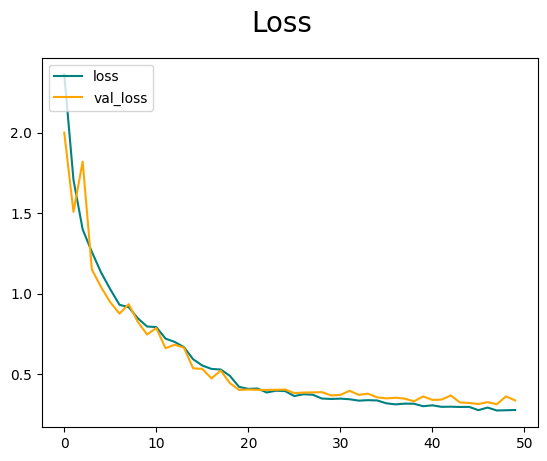

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

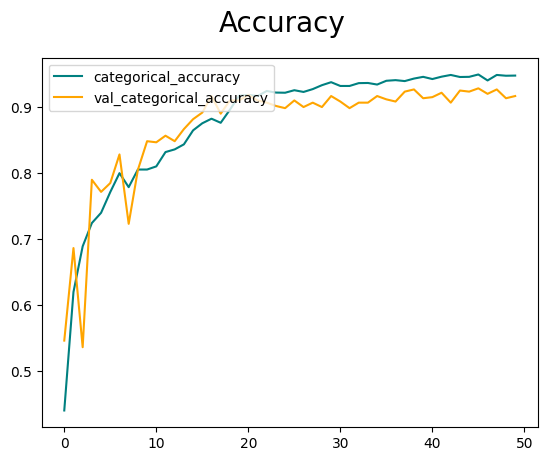

In [18]:
fig = plt.figure()
plt.plot(hist.history['categorical_accuracy'], color='teal', label='categorical_accuracy')
plt.plot(hist.history['val_categorical_accuracy'], color='orange', label='val_categorical_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [20]:
model.save(os.path.join('models','birdclassifier95.keras'))

In [14]:
# def find_duplicate_images(folder_path):
#   duplicates = {}
#   for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#       # Read the image file in binary mode
#       with open(file_path, 'rb') as f:
#         # Generate SHA-1 hash of the image content
#         image_hash = hashlib.sha1(f.read()).hexdigest()
#       if image_hash in duplicates:
#         duplicates[image_hash].append(file_path)
#       else:
#         duplicates[image_hash] = [file_path]
#   return duplicates

# def remove_duplicates(duplicates):
#   for image_hash, files in duplicates.items():
#     if len(files) > 1:
#       # Remove all duplicate files except the first one (assumed original)
#       for file in files[1:]:
#         os.remove(file)
#         print(f"Deleted duplicate: {file}")

# if __name__ == "__main__":
#   folder_path = "train/Rock Pigeon"  # Replace with your actual folder path
#   duplicates = find_duplicate_images(folder_path)
#   remove_duplicates(duplicates)  # Automatic deletion, confirmation set to False by default
